# Deep Convolutional GAN and Cycle-GAN


Generative Adversarial Networks are deep generative models that use two neural networks, a discriminator and a generator which compete one against the other in order to generate new examples of data that are very similar to the real data. GANs' architecture can be particularly interesting for image generation. It is with good reason that the Portrait of Edmond Belamy, generated with a GAN, was sold 432 500 dollars. 

In this notebook, we will implement two GANs to generate images. Firstly, we are going to implement a Deep Convolutional GAN that will generate images from noise. Secondly, we are going to consider a more advanced architecture that combines two GANs and which can be used to “translate” images with different characteristics, the Cycle GAN. The first model will learn to generate images of handwritten digits that could be part of the MNIST dataset, and the second one will be trained to translate images from the MNIST dataset to the USPS one (which is also a dataset of handwritten digits).

## Deep Convolutional Generative Adversarial Networks

As explained in the first section of the bibliographical review, Deep Convolutional GANs (DCGANs) are generative models that aim to generate images from a vector of noise. The images created by the generator should be very similar to those that are in the real dataset, in order to fool the discriminator which goal is to classify them in the fake class (the real examples should be classified in the real class).

### The data

First of all, let's take a look at the MNIST dataset. As a preprocessing, we will just rescale the images in order to have matrices with coefficients that are in the range [-1, 1], and reshape them in order to have a chanel dimension.

In [1]:
import numpy as np
from keras.datasets import mnist

(X_imgs, _) , (_, _) = mnist.load_data()

# Rescale -1 to 1
X_imgs = X_imgs / (255 / 2) - 1.
# Reshape (nb_imgs, nb_rows, nb_cols, 1)
X_imgs = np.expand_dims(X_imgs, axis=3)

Using TensorFlow backend.


In [2]:
X_imgs.shape

(60000, 28, 28, 1)

As we can see, there are 60000 images of dimension (28, 28, 1). \
Here is an example image from the MNIST dataset:

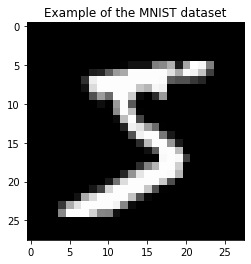

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_imgs[0].reshape(28, 28), cmap='gray')
plt.title('Example of the MNIST dataset')
plt.show()

### The Discriminator and the Generator architectures

The discriminator of a DCGAN is a succession of 4 Convolutional layers with a kernel size of (5x5), strides of 2 and SAME padding. The Leaky ReLU activation was used after each of the three first layers, as suggested in the paper about DCGANs, and the sigmoid function was used after the last layer, in order to have a binary classification. A Batch normalization was also used after the three first layers in order to increase the model stability. The model was finally compiled with an Adam optimizer and a binary crossentropy loss.

The same discriminator was used later for the Cycle GAN, that's why I chose to create a Discriminator class and then a DCDiscriminator class that inherits from the first one.

In [4]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [5]:
class Discriminator:
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.chanels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.chanels)

    def get_model(self):
        model = Sequential()

        model.add(Conv2D(28, kernel_size=5, strides=2, padding='same',
                input_shape=self.img_shape))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2D(56, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2D(112, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2D(1, kernel_size=5, strides=4, padding='same'))
        model.add(Activation('sigmoid'))
        model.add(Reshape((1,)))

        model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.0002, 0.5),
                  metrics=['accuracy'])

        return model

In [6]:
class DCDiscriminator(Discriminator):
    def __init__(self):
        super().__init__()
        self.disc = self.get_model()

In [7]:
dc_disc = DCDiscriminator()
dc_disc.disc.summary()

W0513 00:02:24.341967 12472 deprecation.py:506] From C:\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 28)        728       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 28)        112       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 56)          39256     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 56)          224       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 56)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 112)        

The generator takes as input a noise vector of dimension (100, 1, 1) and outputs an image which dimension is the same as that of the real images. The first layer is a dense layer followed by a reshape, a batch normalization and a relu activation function. Then, three upsampling layers allow to increase the two first dimensions of the matrice (number of rows, number of columns) in order to have an output of the good dimension (here (28, 28, 1)). As suggested in the paper, the tanh activation function was used in the last layer instead of the relu function. 

In [8]:
class DCGenerator:
    def __init__(self):
        self.gen_input_shape = 100
        self.channels = 1

        self.gen = self.get_model()

    def get_model(self):
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation='relu',
        input_shape=(self.gen_input_shape,)))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        return model

In [9]:
dc_gen = DCGenerator()
dc_gen.gen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 128)      

### The DCGAN

Now that the generator and the discriminator architectures are implemented, we should combine them into a model that takes a noise input and outputs an image for the generator and takes an image input and outputs a classification for the discriminator. The discriminator was already compiled as it simply does a binary classification, but it is not the case for the generator. In order to be able to train the generator, we must define a model where the input is a noise vector, and the output is the discriminator classification of the generated images. The generator will learn to fool the discriminator, meaning that the goal of the combined model will be to classify generated images as real. Note that when training the generator, the discriminator must be fixed, so we must precise that in the combined model, the layers corresponding to the discriminator should not be trainable.

The class DCGan below will have a combine_models method that defines the combined architecture that will allow to train the generator to generate fake images. It also has a gen_predict, disc_predict, gen_train and disc_train methods which will be used in the training and predicting tasks of the generator and the discriminator. Finally, I added a plot_imgs method in order to plot examples of the generated images.

In [10]:
class DCGan:
    def __init__(self):
        self.disc = DCDiscriminator().disc
        self.gen = DCGenerator().gen
        self.gan = self.combine_models()

    def combine_models(self):
        gen_input = self.gen.input
        gen_output = self.gen.output
        disc_output = self.disc(gen_output)
        model_combined = Model(gen_input, disc_output)

        self.disc.trainable = False

        model_combined.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.0002, 0.5),
                  metrics=['accuracy'])

        return model_combined

    def gen_predict(self, x):
        return self.gen.predict(x)

    def disc_predict(self, x):
        return self.disc.predict(x)

    def disc_train(self, x, y):
        self.disc.train_on_batch(x, y)

    def gen_train(self, x, y):
        self.gan.train_on_batch(x, y)

    def plot_imgs(self, imgs=None):
        r, c = 4, 4
        if imgs is None:
            noise = np.random.normal(0, 1, (r * c, self.gen.gen_input_shape))
            imgs = self.gen_predict(noise)
        else:
            imgs = imgs[:r * c]

        # Rescale images 0 - 1
        imgs = 0.5 * imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs[cnt].reshape(28, 28), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

In [11]:
dc_gan = DCGan()
dc_gan.gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       4097

### The training

The DCGAN training procedure is as follows:

1) Draw m training examples $(x_1, ..., x_m)$ from the real data\
2) Draw m noise samples $(z_1, ..., z_m)$ from the noise distribution\
3) Generate fake images $G(z_1), ..., G(z_m)$\
4) Train the discriminator\
5) Draw m new noise samples from the noise distribution\
6) Generate fake images from the noise\
7) Train the generator

This procedure is repeated until the generator begin to generate good images.

In [12]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

batch_size = 64
gen_input_shape = 100
epochs = 4000
verbose = 1000
plot_interval = 1000

W0513 00:02:26.904614 12472 module_wrapper.py:139] From C:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0513 00:02:37.843653 12472 deprecation.py:323] From C:\anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 [D loss: 0.244628] [G loss: 0.248963]


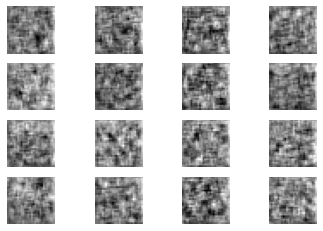

1000 [D loss: 0.319214] [G loss: 0.569951]


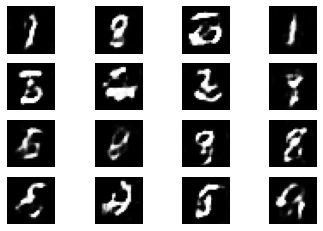

2000 [D loss: 0.391947] [G loss: 0.767223]


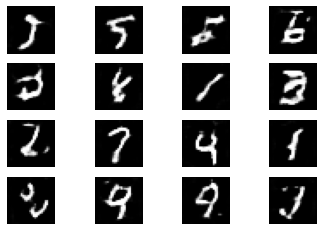

3000 [D loss: 0.399018] [G loss: 0.786002]


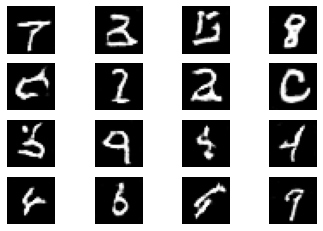

4000 [D loss: 0.393022] [G loss: 0.774083]


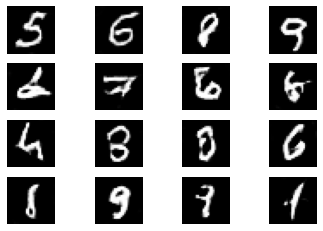

In [13]:
## Training Deep Convolutional GAN

for epoch in range(epochs+1):
    idx = np.random.randint(X_imgs.shape[0], size=batch_size)
    imgs = X_imgs[idx]
    noise = np.random.normal(0, 1, (batch_size, gen_input_shape))
    gen_imgs = dc_gan.gen_predict(noise)

    preds_real = dc_gan.disc_predict(imgs)
    preds_fake = dc_gan.disc_predict(gen_imgs)
    discriminator_loss = ((preds_real - 1)**2 + preds_fake**2).mean() / 2

    dc_gan.disc_train(imgs, np.ones(batch_size))
    dc_gan.disc_train(gen_imgs, np.zeros(batch_size))

    noise = np.random.normal(0, 1, (batch_size, gen_input_shape))
    gen_imgs = dc_gan.gen_predict(noise)

    preds_fake = dc_gan.disc_predict(gen_imgs)
    generator_loss = ((preds_fake - 1)**2).mean()

    dc_gan.gen_train(noise, np.ones(batch_size))

    if epoch % verbose == 0:
        print ("%d [D loss: %f] [G loss: %f]" % (epoch, discriminator_loss,
        generator_loss))

    if epoch % plot_interval == 0:
        dc_gan.plot_imgs(imgs=gen_imgs)

As we can see, the generator gives good results after 4000 training steps, and the images look like the real ones. Moreover, it seems that the learning is progressive, since the generated images looks more and more real as the gerenator is trained. This shows that it doesn't simply overfit.

## Cycle Generative Adversarial Networks

Cycle GANs are generative models that aim to translate images from one domain to the other.\
Cycle GANs are particularly interesting since they allow us to use un-paired training data, meaning that we do not have to have exact correspondences between individual images in the two domains. Thus, they learn a mapping from one domain X to another domain Y without having to find perfectly matched training pairs.

### The data

Here, we are going to translate from MNIST images to USPS images.\
Let's take a look at the USPS dataset, that I have dowloaded from the Kaggle competition that you can find here : https://www.kaggle.com/bistaumanga/usps-dataset

In [14]:
import h5py
import cv2

path = 'dataset/usps-dataset/usps.h5'
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        Y = train.get('data')[:]

Then, I reshaped and resized the images in order to make them have the same dimensions as those of the MNIST images.

In [15]:
# Reshape (nb_imgs, nb_rows, nb_cols)
Y = Y.reshape(Y.shape[0], np.sqrt(Y.shape[1]).astype(int),
        np.sqrt(Y.shape[1]).astype(int))

# Resize to (nb_imgs, 28, 28) (so that a mnist img and an usps img have the same dimensions)
Y_imgs = np.zeros(shape=(Y.shape[0], 28, 28))
for i in range(len(Y_imgs)):
    Y_imgs[i] = cv2.resize(Y[i], dsize=(28, 28))

# Rescale -1 to 1
Y_imgs = Y_imgs / (255 / 2) - 1.

# Reshape (nb_imgs, nb_rows, nb_cols, 1)
Y_imgs = np.expand_dims(Y_imgs, axis=3)

In [16]:
Y_imgs.shape

(7291, 28, 28, 1)

We have 7291 images of dimension (28, 28, 1).\
Here is an example image from the USPS dataset:

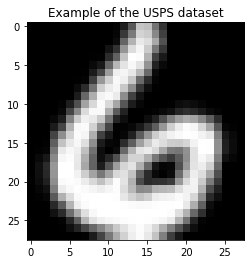

In [17]:
plt.imshow(Y_imgs[0].reshape(28, 28), cmap='gray')
plt.title('Example of the USPS dataset')
plt.show()

As we can see, there are not big differences between MNIST images and USPS images, both of them are handwritten digits and the writing is really similar. This can make the training easier, but it can also make it harder to decide whether the algorithm translates well or not.

### The Discriminator and Generator architectures

Cycle GAN is a network composed of two discriminators and two generators. In fact, there is:

- gen_xy : the generator model that translates images from domain X to domain Y. Thus, it generates images similar to those in domain Y from images in domain X.
- gen_yx : the generator model that translates images from domain Y to domain X. Thus, it generates images similar to those in domain X from images in domain Y.
- disc_x : the discriminator model that classifies real images from domain X and images generated by gen_yx into the two classes real/fake.
- disc_y : the discriminator model that classifies real images from domain Y and images generated by gen_xy into the two classes real/fake.

For the two discriminators disc_x and disc_y, I chose to use the same architecture as the one of the discriminator of the DC-GAN.

In [18]:
class CycleDiscriminator(Discriminator):
    def __init__(self):
        super().__init__()
        self.disc_x = self.get_model()
        self.disc_y = self.get_model()

In [19]:
cycle_disc = CycleDiscriminator()
cycle_disc.disc_x.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 28)        728       
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 28)        112       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 56)          39256     
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 56)          224       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 56)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 112)        

The generators have a more complex architecture.\
Each one has three stages of computation:

1) The first stage is made of convolutional layers to encode the input and extract the image features.\
2) The second stage transforms the features by passing them through one or more residual blocks. A residual block is a succession of convolutional layers that don't change the dimension (in each convolution within the residual block, the input and the output dimensions are the same), followed by a concatenation layer that adds the input of the residual block to the output of the succession of convolutions.\
3) the third stage is made of transpose convolutional layers to decode the transformed features and build an output image of the same size as the input.

In [20]:
class CycleGenerator:
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.chanels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.chanels)

        self.gen_xy = self.get_model()
        self.gen_yx = self.get_model()

    def get_model(self):

        def conv2d(input_layer, filters, kernel_size, strides, padding):
            conv = Conv2D(filters=filters, kernel_size=kernel_size,
            strides=strides, padding=padding)(input_layer)
            conv = BatchNormalization()(conv)
            conv = LeakyReLU()(conv)
            return conv

        def residual_block(input_layer, filters, kernel_size):
            res = Conv2D(filters=filters, kernel_size=kernel_size,
            padding='same')(input_layer)
            res = BatchNormalization()(res)
            res = Activation('relu')(res)

            res = Conv2D(filters=filters, kernel_size=kernel_size,
            padding='same')(res)
            res = BatchNormalization()(res)

            res = Concatenate()([res, input_layer])
            return res

        def deconv2d(input_layer, filters, kernel_size):
            deconv = UpSampling2D()(input_layer)
            deconv = Conv2D(filters=filters, kernel_size=kernel_size,
            padding='same')(deconv)
            deconv = BatchNormalization()(deconv)
            return deconv

        input_img = Input(shape=self.img_shape)

        # first stage : convolutional layers to encode the input
        x = conv2d(input_img, 28, 5, 2, 'same')
        x = conv2d(x, 56, 5, 2, 'same')

        # second stage : residual block to transform the features
        x = residual_block(x, 56, 5)

        # third stage : transpose convolutional layers to decode the transformed
        # features
        x = deconv2d(x, 28, 5)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = deconv2d(x, 1, 5)
        output_img = Activation('tanh')(x)

        model = Model(input_img, output_img)

        return model

In [21]:
cycle_gen = CycleGenerator()
cycle_gen.gen_xy.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 14, 14, 28)   728         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 14, 14, 28)   112         conv2d_23[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 14, 14, 28)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

### The CycleGAN

As it was the case for the DCGAN, we must implement a combined model in order to train each generator. Thus, two combined models are implemented.

The main idea behind the Cyle GAN is the idea of the cycle. In fact, the model must be trained on three different types of cycles:

1) Indentity cycle : the combined model aiming to train gen_xy must be trained so that if we give a real image from domain y as input to the generator, it must give as output the input (the transformation that should be learnt is the identity). The same goes for gen_yx if we give a real image from domain x to it.

2) Forward cycle : each combined model must generate realistic images from the generated images of the other generator. The idea is that when we translate an image from domain X to domain Y , and then translate the generated image back to domain X, the result should look like the original image that we started with. In other terms :\
- gen_xy(gen_yx(y)) must fool disc_y and generate an image that looks like y
- gen_yx(gen_xy(x)) must fool disc_x and generate an image that looks like x 

3) Backward cycle : the combined model aiming to train gen_xy must be trained so that it generates realistic images from images generated by gen_yx which input was an image from domain X. In other terms, gen_xy(gen_yx(x)) must fool disc_y and generate an image that could be part ofdomain X. The same goes fo gen_xy if we give an image generated from gen_yx(y) to it.

In [22]:
class CycleGan:
    def __init__(self):
        self.cycle_disc = CycleDiscriminator()
        self.disc_x = self.cycle_disc.disc_x
        self.disc_y = self.cycle_disc.disc_y

        self.cycle_gen = CycleGenerator()
        self.gen_xy = self.cycle_gen.gen_xy
        self.gen_yx = self.cycle_gen.gen_yx

        self.gan_xy, self.gan_yx = self.combine_models()

    def define_composite_model(self, gen_1, disc, gen_2):
        gen_1.trainable = True
        disc.trainable = False
        gen_2.trainable = False

        gen_1_input = Input(shape=self.cycle_gen.img_shape)
        gen_1_output = gen_1(gen_1_input)
        disc_output = disc(gen_1_output)

        # identity element
        identity_input = Input(shape=self.cycle_gen.img_shape)
        identity_output = gen_1(identity_input)

        # forward cycle
        forward_output = gen_2(gen_1_output)

        # backward cycle
        gen_2_output = gen_2(identity_input)
        backward_output = gen_1(gen_2_output)

        model = Model([gen_1_input, identity_input], [disc_output, identity_output,
        forward_output, backward_output])

        model.compile(loss=['mse', 'mae', 'mae', 'mae'],
                    optimizer=Adam(0.0002, 0.5),
                    metrics=['accuracy'])

        return model

    def combine_models(self):
        model_combined_xy = self.define_composite_model(self.gen_xy, self.disc_y,
        self.gen_yx)
        model_combined_yx = self.define_composite_model(self.gen_yx, self.disc_x,
        self.gen_xy)
        return model_combined_xy, model_combined_yx

    def gen_xy_predict(self, x):
        return self.gen_xy.predict(x)

    def gen_yx_predict(self, x):
        return self.gen_yx.predict(x)

    def disc_x_predict(self, x):
        return self.disc_x.predict(x)

    def disc_y_predict(self, x):
        return self.disc_y.predict(x)

    def disc_x_train(self, x, y):
        return self.disc_x.train_on_batch(x, y)

    def disc_y_train(self, x, y):
        return self.disc_y.train_on_batch(x, y)

    def gen_xy_train(self, x, y):
        return self.gan_xy.train_on_batch(x, y)

    def gen_yx_train(self, x, y):
        return self.gan_yx.train_on_batch(x, y)

    def plot_imgs(self, imgs):
        r, c = 4, 4
        imgs = imgs[:r * c]

        # Rescale images 0 - 1
        imgs = 0.5 * imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs[cnt].reshape(28, 28), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

In [23]:
cycle_gan = CycleGan()
cycle_gan.gan_xy.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 28, 28, 1)    277037      input_5[0][0]                    
                                                                 input_6[0][0]                    
                                                                 model_5[2][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
____________________________________________________________________________________________

### The training

The Cycle GAN training procedure is very similar to the one of the DC-GAN, except that here we must train two generators and two discriminators.

The prodecure is as follows:

1) Draw m training examples $(x_1, ..., x_m)$ from the real data of domain X\
2) Draw m training examples $(y_1, ..., y_m)$ from the real data of domain Y\
3) Train the discriminators\
4) Train the generators

Below, we will show some examples of generated images. Every 1000 steps, we show two sets of images: the set on the top is the set of input images that really belong to the MNIST database, and the set on the bottom is the set of the corresponding generated images.

0 [Dx loss: 0.887070] [Dy loss: 0.692307] [Gxy loss: 3.290550] [Gyx loss: 2.777010]


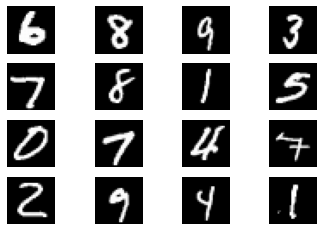

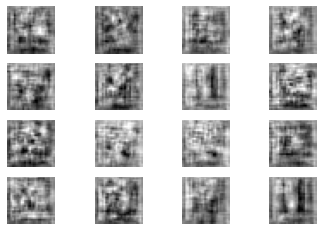

1000 [Dx loss: 0.000041] [Dy loss: 0.001858] [Gxy loss: 2.685353] [Gyx loss: 1.465423]


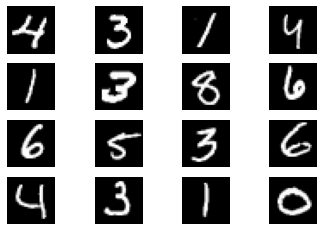

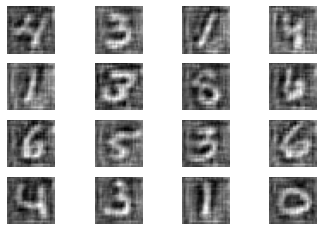

2000 [Dx loss: 0.000007] [Dy loss: 0.000025] [Gxy loss: 2.262882] [Gyx loss: 1.032370]


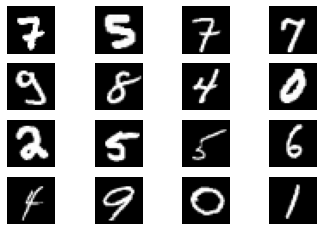

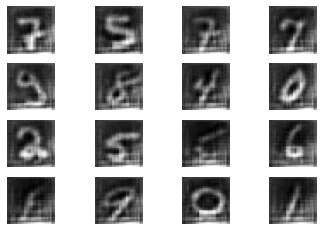

3000 [Dx loss: 0.000001] [Dy loss: 0.000005] [Gxy loss: 1.968629] [Gyx loss: 0.759835]


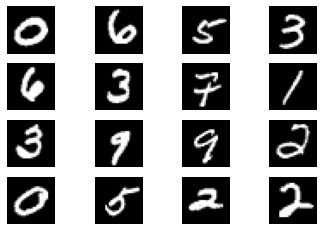

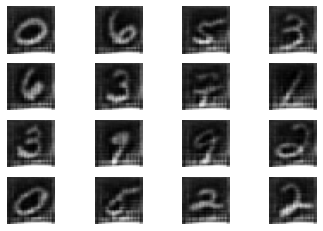

4000 [Dx loss: 0.000000] [Dy loss: 0.000001] [Gxy loss: 1.783718] [Gyx loss: 0.595249]


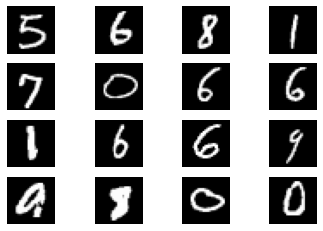

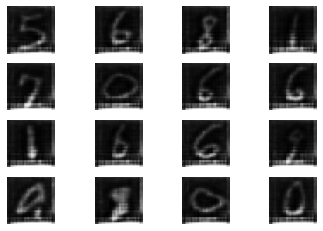

In [24]:
## Training Cycle GAN

for epoch in range(epochs+1):
    idx_x = np.random.randint(X_imgs.shape[0], size=batch_size)
    imgs_x = X_imgs[idx_x]

    idx_y = np.random.randint(Y_imgs.shape[0], size=batch_size)
    imgs_y = Y_imgs[idx_y]

    gen_imgs_y = cycle_gan.gen_xy_predict(imgs_x)
    gen_imgs_x = cycle_gan.gen_yx_predict(imgs_y)

    disc_x_loss_real = cycle_gan.disc_x_train(imgs_x, np.ones(batch_size))[0]
    disc_x_loss_fake = cycle_gan.disc_x_train(gen_imgs_x, np.zeros(batch_size))[0]
    disc_x_loss = (disc_x_loss_real + disc_x_loss_fake) / 2

    disc_y_loss_real = cycle_gan.disc_y_train(imgs_y, np.ones(batch_size))[0]
    disc_y_loss_fake = cycle_gan.disc_y_train(gen_imgs_y, np.zeros(batch_size))[0]
    disc_y_loss = (disc_y_loss_real + disc_y_loss_fake) / 2

    gen_xy_loss = cycle_gan.gen_xy_train([imgs_x, imgs_y],[np.ones(batch_size), imgs_y,
    imgs_x, imgs_y])[0]
    gen_yx_loss = cycle_gan.gen_yx_train([imgs_y, imgs_x], [np.ones(batch_size), imgs_x,
    imgs_y, imgs_x])[0]
    
    if epoch % verbose == 0:
        print("%d [Dx loss: %f] [Dy loss: %f] [Gxy loss: %f] [Gyx loss: %f]" % (epoch,
        disc_x_loss, disc_y_loss, gen_xy_loss, gen_yx_loss))

    if epoch % plot_interval == 0:
        cycle_gan.plot_imgs(imgs=imgs_x)
        cycle_gan.plot_imgs(imgs=gen_imgs_y)

As we can see, the Cycle GAN learns to generate digit images. However, the generated images are very similar to the input images, and we can think that the generator simply learns to reproduce the input data. We cannot assess the quality of the algorithm since the images from the two domains are quite the same.